# Medical Image Analysis YOLOv8 Updated With Comments and Docstrings

In [1]:
"""Install or upgrade the Ultralytics YOLOv8 library."""
!pip install ultralytics --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.8/978.8 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing i

In [2]:
"""Import required libraries and set random seed for reproducibility."""
import random, shutil, os, yaml, itertools
from pathlib import Path
from ultralytics import YOLO

# reproducibility
random.seed(42)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
"""Set up source and destination directories for reorganizing the dataset structure."""

SRC_ROOT = Path("/kaggle/input/labeled-mri-brain-tumor-dataset/Brain Tumor labeled dataset")

# Find any path containing 'glioma' to confirm the structure, then get its parent directory
for p in SRC_ROOT.rglob("*glioma*"):
    SRC_ROOT = p.parents[0]    # Note: in this case, we do not traverse further up
    break

DEST_ROOT = Path("/kaggle/working/brain_split") # New destination folder for split dataset

# Define image and label directories for train, validation, and test sets
IMG_DIRS  = {s: DEST_ROOT/s/"images"  for s in ["train","val","test"]}
LBL_DIRS  = {s: DEST_ROOT/s/"labels"  for s in ["train","val","test"]}

# Create the directories if they don't already exist
for d in itertools.chain(IMG_DIRS.values(), LBL_DIRS.values()):
    d.mkdir(parents=True, exist_ok=True)

------------------------------
## Dataset Preparation: Image and Label Splitting
In this section, we split the dataset into training, validation, and test sets, ensuring each image is paired with the appropriate label file. This step prepares the data structure required for YOLOv8 training.

In [4]:
"""Split dataset into train, validation, and test folders with corresponding labels."""

splits   = {"train":0.6, "val":0.2, "test":0.2}  # split ratios

# Get class directories (e.g., glioma, meningioma, etc.)
classes  = [d for d in SRC_ROOT.iterdir() if d.is_dir()]            
print("Found classes:", [c.name for c in classes])

def copy_pair(src_img:Path, dest_split:str):
    """"
    Copy an image and its corresponding label file (.txt) to the appropriate split folder.

    Parameters:
        src_img (Path): Path to the source image file.
        dest_split (str): The target split name ('train', 'val', or 'test').

    Returns:
        None: Files are copied to IMG_DIRS and LBL_DIRS in-place.
    """
    dst_img = IMG_DIRS[dest_split]/src_img.name
    dst_lbl = LBL_DIRS[dest_split]/(src_img.stem + ".txt")
    shutil.copy2(src_img, dst_img)
    label_src = src_img.with_suffix(".txt")
    # Copy label if exists, otherwise create an empty label file (negative sample)
    if label_src.exists():
        shutil.copy2(label_src, dst_lbl)
    else:
        dst_lbl.touch()                                                   

# Iterate over each class folder and assign images to splits
for cls_dir in classes:
    imgs = sorted(cls_dir.glob("*.jpg")) + sorted(cls_dir.glob("*.png"))
    random.shuffle(imgs)

    n = len(imgs)
    n_train = int(n * splits["train"])
    n_val   = int(n * splits["val"])
    
    # Create split mapping list according to the defined ratios
    split_map = (
        ["train"]*n_train +
        ["val"]  *n_val   +
        ["test"] * (n - n_train - n_val)
    )

    # Copy each image and its label to the corresponding split folder
    for img_path, split_name in zip(imgs, split_map):
        copy_pair(img_path, split_name)

# Confirm how many images were placed in each split folder
print("Split finished ➜",
      {k: len(list(IMG_DIRS[k].glob('*'))) for k in IMG_DIRS})

# Expected output:
# Found classes: ['pituitary', 'notumor', 'meningioma', 'glioma']
# Split finished ➜ {'train': 1305, 'val': 435, 'test': 435}

Found classes: ['pituitary', 'notumor', 'meningioma', 'glioma']
Split finished ➜ {'train': 1305, 'val': 435, 'test': 435}


-----------------------------
## Creating the YAML Configuration File for YOLO Training
This section defines and writes a custom YAML file that YOLOv8 uses to understand the dataset structure and class mappings.

In [5]:
"""Create and write a YAML configuration file for YOLO training."""

yaml_dict = {
    "path": str(DEST_ROOT),       # Root directory
    "train":  "train/images",     # Relative path to train images
    "val":    "val/images",       # Relative path to validate images
    "test":   "test/images",      # Relative path to test images
    "nc":     4,                  # Number of classes
    "names":  ["glioma", "meningioma", "no_tumor", "pituitary"] # Class names
}

# Write the dictionary to a YAML file
with open("brain_tumor.yaml", "w") as f:
    yaml.dump(yaml_dict, f, sort_keys=False)
    
print("brain_tumor.yaml written!")

brain_tumor.yaml written!


## Model Initialization
We initialize and use the YOLOv8n model in this project, chosen for its balance of speed and accuracy in medical image detection tasks.

In [6]:
model = YOLO("yolov8n.pt")   

100%|██████████| 6.25M/6.25M [00:00<00:00, 121MB/s]


While training for 80 epochs may seem excessive, the model already performs well with just 10. However, increasing the number of epochs can help improve accuracy further through additional fine-tuning.

In [7]:
"""Train the YOLOv8 model on the brain tumor dataset using the specified configuration."""

results = model.train(
    data="brain_tumor.yaml",
    imgsz=640,
    epochs=80,
    batch=16,
    patience=15,
    project="brain_mri_yolov8",
    name="yolov8n_brain_tumor"
)

Ultralytics 8.3.111 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=brain_tumor.yaml, epochs=80, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=brain_mri_yolov8, name=yolov8n_brain_tumor, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

100%|██████████| 755k/755k [00:00<00:00, 26.0MB/s]
E0000 00:00:1745194592.181625      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745194592.235414      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 113MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 764.0±287.9 MB/s, size: 27.1 KB)


train: Scanning /kaggle/working/brain_split/train/labels... 1305 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1305/1305 [00:00<00:00, 1544.78it/s]

train: New cache created: /kaggle/working/brain_split/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 508.0±388.0 MB/s, size: 22.2 KB)


val: Scanning /kaggle/working/brain_split/val/labels... 435 images, 0 backgrounds, 0 corrupt: 100%|██████████| 435/435 [00:00<00:00, 1399.44it/s]

val: New cache created: /kaggle/working/brain_split/val/labels.cache


Plotting labels to brain_mri_yolov8/yolov8n_brain_tumor/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to brain_mri_yolov8/yolov8n_brain_tumor
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80      2.16G      1.759      3.495      1.821         17        640: 100%|██████████| 82/82 [00:16<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.76it/s]


                   all        435        437      0.949      0.227      0.476      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80      2.66G      1.589      2.417      1.642         11        640: 100%|██████████| 82/82 [00:14<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.44it/s]


                   all        435        437      0.782       0.44      0.539      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80      2.66G      1.613      2.104      1.659         17        640: 100%|██████████| 82/82 [00:14<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.02it/s]


                   all        435        437      0.805      0.546      0.634      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      2.66G      1.599      1.802      1.651         17        640: 100%|██████████| 82/82 [00:14<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.14it/s]

                   all        435        437      0.562      0.557      0.592      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80      2.66G       1.58      1.616      1.618         12        640: 100%|██████████| 82/82 [00:14<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.13it/s]

                   all        435        437      0.753      0.658      0.737       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      2.66G      1.555      1.459      1.573         16        640: 100%|██████████| 82/82 [00:14<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.14it/s]

                   all        435        437      0.548      0.605      0.617      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      2.66G      1.519      1.388      1.563         18        640: 100%|██████████| 82/82 [00:14<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.15it/s]

                   all        435        437      0.695      0.686      0.736      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80      2.66G      1.535      1.342      1.569         19        640: 100%|██████████| 82/82 [00:14<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.09it/s]

                   all        435        437      0.682      0.683      0.771       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80      2.66G      1.479      1.282      1.557         23        640: 100%|██████████| 82/82 [00:14<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.22it/s]

                   all        435        437      0.787      0.728      0.818      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80      2.66G      1.473       1.19      1.525         21        640: 100%|██████████| 82/82 [00:14<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.23it/s]

                   all        435        437      0.769      0.645      0.723       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80      2.66G      1.455      1.188      1.516         19        640: 100%|██████████| 82/82 [00:14<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.08it/s]

                   all        435        437      0.739      0.726      0.794      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80      2.66G      1.412      1.124      1.493         18        640: 100%|██████████| 82/82 [00:14<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.75it/s]

                   all        435        437      0.822      0.712      0.796      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80      2.66G      1.444      1.142      1.519         19        640: 100%|██████████| 82/82 [00:14<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.10it/s]

                   all        435        437      0.807      0.762      0.841      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80      2.66G      1.424      1.068      1.478         19        640: 100%|██████████| 82/82 [00:14<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.25it/s]

                   all        435        437      0.842       0.77      0.833      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80      2.66G      1.427      1.092      1.512         18        640: 100%|██████████| 82/82 [00:14<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.17it/s]

                   all        435        437      0.788      0.713      0.801      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80      2.66G      1.417      1.059       1.47         13        640: 100%|██████████| 82/82 [00:14<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.24it/s]

                   all        435        437      0.779       0.68      0.771      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80      2.66G      1.406      1.043      1.477         16        640: 100%|██████████| 82/82 [00:14<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.26it/s]

                   all        435        437      0.834      0.789      0.854      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80      2.66G      1.366      1.008      1.456         11        640: 100%|██████████| 82/82 [00:14<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.95it/s]

                   all        435        437      0.816      0.746       0.83       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80      2.66G      1.402     0.9911      1.452         20        640: 100%|██████████| 82/82 [00:14<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.27it/s]

                   all        435        437      0.787      0.725        0.8       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80      2.66G      1.368     0.9755      1.451         15        640: 100%|██████████| 82/82 [00:14<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.26it/s]

                   all        435        437      0.859      0.815      0.878       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80      2.66G      1.382     0.9369      1.456         17        640: 100%|██████████| 82/82 [00:14<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.25it/s]

                   all        435        437      0.828       0.81      0.854      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80      2.66G      1.359     0.9624      1.429         17        640: 100%|██████████| 82/82 [00:14<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.28it/s]

                   all        435        437      0.836       0.83      0.881      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80      2.66G      1.344     0.9278       1.44         18        640: 100%|██████████| 82/82 [00:14<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.22it/s]

                   all        435        437      0.824      0.809      0.874      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80      2.66G      1.335     0.8823      1.412         23        640: 100%|██████████| 82/82 [00:14<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.10it/s]

                   all        435        437      0.857      0.818      0.866      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80      2.66G      1.328     0.9041      1.423         16        640: 100%|██████████| 82/82 [00:14<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.13it/s]

                   all        435        437      0.886      0.785      0.879      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80      2.66G      1.319     0.8841      1.406         19        640: 100%|██████████| 82/82 [00:14<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.35it/s]

                   all        435        437      0.878      0.793      0.886      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80      2.66G      1.282      0.838      1.397         16        640: 100%|██████████| 82/82 [00:14<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.72it/s]

                   all        435        437       0.83      0.798      0.853      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80      2.66G      1.319     0.8313      1.396         23        640: 100%|██████████| 82/82 [00:14<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.28it/s]

                   all        435        437      0.852       0.86      0.895       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80      2.66G      1.305     0.8518      1.405         20        640: 100%|██████████| 82/82 [00:14<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.05it/s]

                   all        435        437       0.81      0.847      0.879      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80      2.66G      1.282     0.8532      1.386         16        640: 100%|██████████| 82/82 [00:14<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.18it/s]

                   all        435        437      0.887      0.839      0.894      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80      2.66G      1.262     0.8069      1.359         23        640: 100%|██████████| 82/82 [00:14<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.06it/s]

                   all        435        437       0.83       0.87      0.896      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80      2.66G       1.27     0.8163      1.385         14        640: 100%|██████████| 82/82 [00:14<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.33it/s]

                   all        435        437      0.869       0.84      0.887      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80      2.66G      1.271     0.7925      1.387         16        640: 100%|██████████| 82/82 [00:14<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.28it/s]

                   all        435        437      0.847      0.818      0.874      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80      2.66G      1.254     0.7736      1.361         15        640: 100%|██████████| 82/82 [00:14<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.26it/s]

                   all        435        437      0.819      0.811       0.87      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80      2.66G      1.257     0.7681      1.357         10        640: 100%|██████████| 82/82 [00:15<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.41it/s]

                   all        435        437      0.847      0.863      0.904      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80      2.66G      1.246     0.7856       1.34         20        640: 100%|██████████| 82/82 [00:14<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.33it/s]

                   all        435        437      0.812      0.823      0.876       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80      2.66G       1.23     0.7472       1.34         18        640: 100%|██████████| 82/82 [00:14<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.11it/s]

                   all        435        437      0.844      0.864      0.888      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80      2.66G      1.234     0.7555      1.364         18        640: 100%|██████████| 82/82 [00:14<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.16it/s]

                   all        435        437      0.846      0.867      0.906      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80      2.66G      1.211     0.7343      1.323         19        640: 100%|██████████| 82/82 [00:14<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.43it/s]

                   all        435        437      0.848      0.876      0.901      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80      2.66G      1.221     0.7293      1.337         17        640: 100%|██████████| 82/82 [00:14<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.74it/s]

                   all        435        437      0.848      0.874      0.889      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80      2.66G      1.177     0.7156       1.33         12        640: 100%|██████████| 82/82 [00:14<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.26it/s]

                   all        435        437      0.855      0.873      0.907      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80      2.66G      1.201     0.7173      1.327         14        640: 100%|██████████| 82/82 [00:14<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.03it/s]

                   all        435        437      0.896      0.828      0.888      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80      2.66G      1.193     0.6914       1.31         15        640: 100%|██████████| 82/82 [00:14<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.18it/s]

                   all        435        437       0.85      0.869      0.893      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80      2.66G      1.204     0.7189      1.327         13        640: 100%|██████████| 82/82 [00:14<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.20it/s]

                   all        435        437      0.877      0.847      0.891      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80      2.66G      1.183     0.6876      1.316         14        640: 100%|██████████| 82/82 [00:14<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.19it/s]

                   all        435        437      0.857       0.85      0.882      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80      2.66G      1.148     0.6674      1.301         15        640: 100%|██████████| 82/82 [00:14<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.28it/s]

                   all        435        437      0.902      0.874      0.913      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80      2.66G      1.156     0.6803       1.29         18        640: 100%|██████████| 82/82 [00:14<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.25it/s]

                   all        435        437      0.905      0.868      0.915      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80      2.66G       1.16     0.6793      1.302         14        640: 100%|██████████| 82/82 [00:14<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.15it/s]

                   all        435        437      0.889       0.87      0.913      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80      2.66G      1.113     0.6595      1.268         12        640: 100%|██████████| 82/82 [00:14<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.32it/s]

                   all        435        437      0.905      0.875      0.909      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80      2.66G      1.149     0.6536      1.288         25        640: 100%|██████████| 82/82 [00:14<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.23it/s]

                   all        435        437      0.901      0.857      0.909      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80      2.66G      1.111     0.6552      1.286         13        640: 100%|██████████| 82/82 [00:14<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.21it/s]

                   all        435        437      0.926      0.873      0.915      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80      2.66G      1.126     0.6499      1.287         16        640: 100%|██████████| 82/82 [00:14<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.34it/s]

                   all        435        437      0.894      0.876      0.912      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80      2.66G      1.127     0.6478      1.292         20        640: 100%|██████████| 82/82 [00:14<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.71it/s]

                   all        435        437      0.914      0.858      0.912      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80      2.66G      1.096     0.6458      1.253         16        640: 100%|██████████| 82/82 [00:14<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.28it/s]

                   all        435        437      0.885      0.893      0.907      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80      2.66G      1.087     0.6299      1.268         15        640: 100%|██████████| 82/82 [00:14<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.13it/s]

                   all        435        437      0.849      0.883      0.901      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80      2.66G      1.091     0.6253      1.269          9        640: 100%|██████████| 82/82 [00:14<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.36it/s]

                   all        435        437       0.88      0.869      0.903      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80      2.66G      1.076     0.6216      1.255         14        640: 100%|██████████| 82/82 [00:14<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.21it/s]

                   all        435        437      0.879      0.866      0.898      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80      2.66G      1.061     0.6175      1.248         14        640: 100%|██████████| 82/82 [00:14<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.40it/s]

                   all        435        437      0.877      0.877       0.91      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80      2.66G       1.07     0.6071      1.244         15        640: 100%|██████████| 82/82 [00:14<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.16it/s]

                   all        435        437      0.855      0.887      0.903      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80      2.66G      1.061     0.6062      1.257         17        640: 100%|██████████| 82/82 [00:14<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.32it/s]

                   all        435        437      0.901      0.871      0.907      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/80      2.66G      1.048     0.5883      1.234         15        640: 100%|██████████| 82/82 [00:14<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.36it/s]

                   all        435        437      0.878      0.896      0.919      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/80      2.66G      1.024     0.5756      1.219         13        640: 100%|██████████| 82/82 [00:14<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.09it/s]

                   all        435        437      0.895      0.893       0.92      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/80      2.66G      1.019     0.5899       1.23         13        640: 100%|██████████| 82/82 [00:14<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.33it/s]

                   all        435        437      0.883      0.905      0.922      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/80      2.66G      1.004     0.5668      1.212         22        640: 100%|██████████| 82/82 [00:14<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.20it/s]

                   all        435        437      0.879      0.876      0.912       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/80      2.66G       1.02     0.5711      1.205         18        640: 100%|██████████| 82/82 [00:14<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.26it/s]

                   all        435        437      0.885      0.879      0.915      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/80      2.66G     0.9995     0.5683      1.201         16        640: 100%|██████████| 82/82 [00:14<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.28it/s]

                   all        435        437      0.896      0.888      0.921      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/80      2.66G     0.9755     0.5556      1.189         15        640: 100%|██████████| 82/82 [00:14<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.37it/s]

                   all        435        437      0.926      0.867      0.919      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/80      2.66G     0.9787     0.5491      1.192         14        640: 100%|██████████| 82/82 [00:14<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.76it/s]

                   all        435        437      0.898      0.879      0.912      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/80      2.66G     0.9706     0.5442      1.188         11        640: 100%|██████████| 82/82 [00:14<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.30it/s]

                   all        435        437      0.914      0.875      0.915      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/80      2.66G     0.9627     0.5394      1.182         17        640: 100%|██████████| 82/82 [00:14<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.19it/s]

                   all        435        437      0.898      0.886      0.915       0.56


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/80      2.66G     0.9651     0.4902      1.231          9        640: 100%|██████████| 82/82 [00:15<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.28it/s]

                   all        435        437      0.896      0.876      0.915      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/80      2.66G     0.9279     0.4615      1.213          9        640: 100%|██████████| 82/82 [00:14<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.42it/s]

                   all        435        437      0.886      0.852      0.909       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/80      2.66G     0.9299     0.4538      1.211          9        640: 100%|██████████| 82/82 [00:14<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.41it/s]

                   all        435        437      0.908      0.868      0.912      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/80      2.66G     0.9007     0.4452      1.187          9        640: 100%|██████████| 82/82 [00:14<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.44it/s]

                   all        435        437      0.907      0.894      0.918      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/80      2.66G     0.8956     0.4318      1.176          9        640: 100%|██████████| 82/82 [00:14<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.32it/s]

                   all        435        437      0.893      0.882      0.915       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/80      2.66G     0.8903     0.4289      1.186          9        640: 100%|██████████| 82/82 [00:14<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.29it/s]

                   all        435        437      0.909      0.882      0.916      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/80      2.66G      0.885     0.4364      1.181          9        640: 100%|██████████| 82/82 [00:14<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.32it/s]

                   all        435        437      0.907       0.88       0.92      0.559
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 62, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



77 epochs completed in 0.370 hours.
Optimizer stripped from brain_mri_yolov8/yolov8n_brain_tumor/weights/last.pt, 6.2MB
Optimizer stripped from brain_mri_yolov8/yolov8n_brain_tumor/weights/best.pt, 6.2MB

Validating brain_mri_yolov8/yolov8n_brain_tumor/weights/best.pt...
Ultralytics 8.3.111 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.52it/s]


                   all        435        437      0.895      0.893       0.92      0.564
                glioma        124        125      0.936       0.93       0.97      0.526
            meningioma        110        110      0.933      0.945      0.978      0.613
              no_tumor         92         93      0.775      0.731      0.755      0.389
             pituitary        109        109      0.938      0.963      0.978      0.726


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to brain_mri_yolov8/yolov8n_brain_tumor


Training automatically stopped at epoch 77, even though we initially planned to run for 80. This saved us time and helped avoid overfitting.

----------------------------
# Final Model Evaluation and Metrics Report

In [9]:
"""Evaluate the best trained YOLOv8 model on the test set and save final metrics."""

best_pt = Path("/kaggle/working/brain_mri_yolov8/yolov8n_brain_tumor/weights/best.pt")
best    = YOLO(best_pt)

# Run evaluation on the test split
test_metrics = best.val(data="brain_tumor.yaml", split="test")

# Extract key evaluation metrics
mp     = test_metrics.box.mp      # mean precision
mr     = test_metrics.box.mr      # mean recall
map50  = test_metrics.box.map50   # mAP@0.50
map5095 = test_metrics.box.map    # mAP@0.50‑0.95

print("\n ---------  FINAL TEST METRICS  ----------")
print(f"│  Precision (mp)      : {mp:.3f}")
print(f"│  Recall    (mr)      : {mr:.3f}")
print(f"│  mAP@0.50           : {map50:.3f}")
print(f"│  mAP@0.50‑0.95      : {map5095:.3f}")
print("---------------------------------------------")

# Save metrics to a text file for reporting
Path("final_test_metrics.txt").write_text(
    f"mp={mp:.4f}, mr={mr:.4f}, map50={map50:.4f}, map={map5095:.4f}\n"
)

Ultralytics 8.3.111 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 668.6±311.3 MB/s, size: 20.8 KB)


val: Scanning /kaggle/working/brain_split/test/labels... 435 images, 0 backgrounds, 0 corrupt: 100%|██████████| 435/435 [00:00<00:00, 1646.75it/s]

val: New cache created: /kaggle/working/brain_split/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.79it/s]


                   all        435        438      0.892      0.877      0.913      0.542
                glioma        124        124      0.967       0.94      0.974      0.534
            meningioma        110        110      0.932      0.909      0.953      0.556
              no_tumor         91         94      0.746      0.688      0.756      0.372
             pituitary        110        110      0.922      0.973      0.968      0.707


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.7ms preprocess, 2.8ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/val

 ---------  FINAL TEST METRICS  ----------
│  Precision (mp)      : 0.892
│  Recall    (mr)      : 0.877
│  mAP@0.50           : 0.913
│  mAP@0.50‑0.95      : 0.542
---------------------------------------------


47

In [10]:
"""Load YOLO training results and extract key metric column names for plotting or analysis."""
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

# Load the results CSV file generated by YOLO training
csv_path = Path("/kaggle/working/brain_mri_yolov8/yolov8n_brain_tumor/results.csv")
df = pd.read_csv(csv_path)

# --- find column names regardless of the "(B)" / "(R)" suffix -------------
def col_like(sub):
    """
    Return the first column name in the DataFrame that contains the given substring.

    Parameters:
        sub (str): Substring to search for in column names.

    Returns:
        str: The matching column name.
    """
    return next(c for c in df.columns if sub in c)

# Dynamically find relevant metric columns based on substring matching
prec_col   = col_like("metrics/precision")
rec_col    = col_like("metrics/recall")
map50_col  = col_like("metrics/mAP50(")       # the '(' avoids map50-95
map5095_col= col_like("metrics/mAP50-95")

# Visualizing Validation Performance Over Epochs

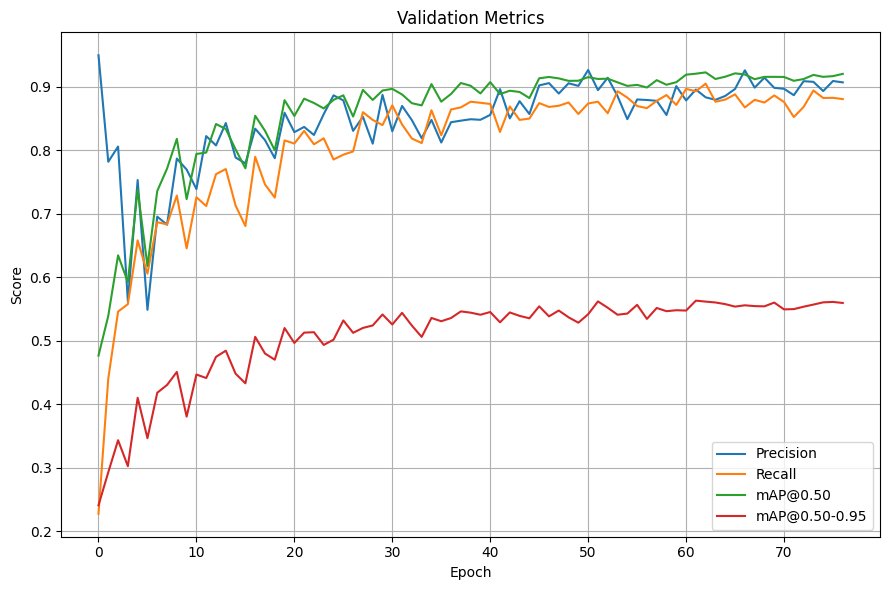

In [11]:
"""Plot validation metrics (Precision, Recall, mAP@0.50, mAP@0.50‑0.95) across epochs."""

# ------------------  METRIC CURVES  ---------------------------------------
plt.figure(figsize=(9,6))

# Plot each validation metric over training epochs
plt.plot(df.index, df[prec_col],   label="Precision")
plt.plot(df.index, df[rec_col],    label="Recall")
plt.plot(df.index, df[map50_col],  label="mAP@0.50")
plt.plot(df.index, df[map5095_col],label="mAP@0.50‑0.95")

plt.xlabel("Epoch"); plt.ylabel("Score"); plt.title("Validation Metrics")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# Training and Validation Loss Analysis

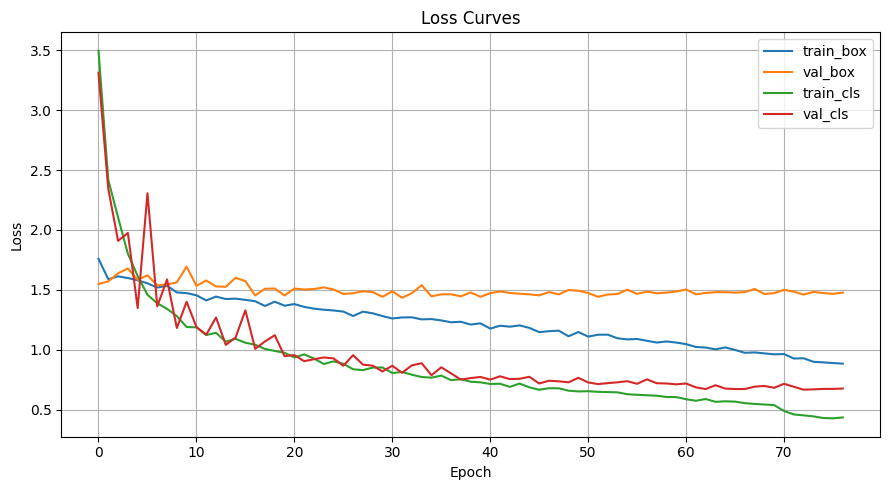

In [12]:
"""Plot training and validation loss curves over epochs for box and class predictions."""

# ------------------  LOSS CURVES  -----------------------------------------
plt.figure(figsize=(9,5))

# Plot training and validation box loss
plt.plot(df.index, df["train/box_loss"], label="train_box")
plt.plot(df.index, df["val/box_loss"],   label="val_box")

# Plot training and validation classification loss
plt.plot(df.index, df["train/cls_loss"], label="train_cls")
plt.plot(df.index, df["val/cls_loss"],   label="val_cls")

plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curves")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

---------------------------
# Save Final Model Weights

In [14]:
"""Copy the best YOLOv8 model weights to a new file for future use or submission."""

from pathlib import Path, PosixPath
import random, shutil, cv2
import numpy as np
from ultralytics.utils.plotting import Annotator
from ultralytics.utils.ops import xywh2xyxy

# Define paths for source and destination model weights
best_pt = Path("/kaggle/working/brain_mri_yolov8/yolov8n_brain_tumor/weights/best.pt")
final_pt = Path("best_brain_tumor_yolov8n.pt")

shutil.copy2(best_pt, final_pt)      # best_brain_tumor_yolov8n.pt saved at /kaggle/working

print(f"Model saved to: {final_pt.resolve()}")

Model saved to: /kaggle/working/best_brain_tumor_yolov8n.pt


---------------------------------
# Custom Evaluation on Random Test Images

In [17]:
"""Perform a custom evaluation of model predictions vs. ground truth on 100 random test images."""

VAL_IMG_DIR = Path("brain_split/test/images")
VAL_LBL_DIR = Path("brain_split/test/labels")

N = 100                       # how many random val images to inspect
tp = fp = fn = 0

def iou_xyxy(boxA, boxB):
    """
    Compute the Intersection over Union (IoU) between two boxes in [x1, y1, x2, y2] format.

    Parameters:
        boxA (list): First bounding box.
        boxB (list): Second bounding box.

    Returns:
        float: IoU value between the two boxes.
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    inter = max(0, xB - xA) * max(0, yB - yA)
    union = ((boxA[2]-boxA[0]) * (boxA[3]-boxA[1]) +
             (boxB[2]-boxB[0]) * (boxB[3]-boxB[1]) - inter)
    return inter / union if union else 0.0


for img_path in random.sample(list(VAL_IMG_DIR.glob("*")), N):
    label_path = VAL_LBL_DIR / (img_path.stem + ".txt")
    pred  = model(img_path, imgsz=640, conf=0.25, iou=0.5, verbose=False)[0]                   

    # --- Load ground truth boxes ---
    h, w = pred.orig_shape
    gt_boxes, gt_cls = [], []
    if label_path.exists():
        for line in label_path.read_text().splitlines():
            c, xc, yc, bw, bh = map(float, line.split())
            x1, y1 = (xc - bw/2) * w, (yc - bh/2) * h
            x2, y2 = (xc + bw/2) * w, (yc + bh/2) * h
            gt_boxes.append([x1, y1, x2, y2]); gt_cls.append(int(c))
            
    # --- Load predicted boxes ---
    pred_boxes = pred.boxes.xyxy.cpu().numpy()
    pred_cls   = pred.boxes.cls.cpu().numpy().astype(int)
    
    matched_gt = set()
    for pb, pc in zip(pred_boxes, pred_cls):
        best_iou, best_idx = 0, -1
        for i, (gb, gc) in enumerate(zip(gt_boxes, gt_cls)):
            if i in matched_gt or pc != gc: continue
            iou = iou_xyxy(pb, gb)
            if iou > best_iou:
                best_iou, best_idx = iou, i
        if best_iou >= 0.5:
            tp += 1; matched_gt.add(best_idx)
        else:
            fp += 1
    fn += len(gt_boxes) - len(matched_gt)

In [18]:
"""Calculate and print precision and recall from the sampled evaluation results."""

prec = tp / (tp+fp) if (tp+fp) else 0
rec  = tp / (tp+fn) if (tp+fn) else 0

print(f"\n{N}‑image sample |  TP={tp} FP={fp} FN={fn}  →  P={prec:.3f}  R={rec:.3f}")


100‑image sample |  TP=89 FP=16 FN=13  →  P=0.848  R=0.873
